# Annual Water Use 

In [16]:

import os, sys
import pandas as pd

from iwateruse.featurize import MultiOneHotEncoder
import matplotlib.pyplot as plt
from xgboost import plot_importance
import xgboost as xgb
import category_encoders as ce 
from lightgbm import LGBMRegressor

#
import numpy as np

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

In [18]:
# %matplotlib widget
# %matplotlib inline
# %matplotlib ipympl
import warnings

warnings.filterwarnings('ignore')
xgb.set_config(verbosity=0)

In [41]:
dataset = pd.read_csv(r"C:\work\water_use\ml_experiments\annual_v_0_0\clean_train_db.csv")
pop_info = pd.read_csv(r"pop_info.csv")
pc_50_swud = pd.read_csv(r"C:\work\water_use\mldataset\ml\training\misc_features\spatial_features\pc_50_pop_swud15.csv")
# pc_50_plc = pd.read_csv(r"C:\work\water_use\mldataset\ml\training\misc_features\spatial_features\pc_50_plc_pop_interpolated.csv")
pc95_5 = pd.read_csv(r"C:\work\water_use\mldataset\ml\training\misc_features\spatial_features\pc_50_swud_pop_p95_5.csv")

In [42]:
df_ = pc_50_swud[['sys_id', 'pc_median' ]]
dataset = dataset.merge(df_, right_on=['sys_id'], left_on=['sys_id'] , how = 'left')
del(df_)

df_ = pc95_5[['sys_id', 'p95', 'p5' ]]
dataset = dataset.merge(df_, right_on=['sys_id'], left_on=['sys_id'] , how = 'left')
del(df_)

In [43]:
# pop_info['pop'] = pop_info['pop_swud16'].copy()
# mask = pop_info['pop'].isna() | pop_info['pop']==0
# pop_info.loc[mask, 'pop'] = pop_info[mask]['plc_pop_interpolated']
# mask = pop_info['pop'].isna() | pop_info['pop']==0
# pop_info.loc[mask, 'pop'] = pop_info[mask]['TPOPSRV']
# mask = pop_info['pop'].isna() | pop_info['pop']==0
# pop_info.loc[mask, 'pop'] = pop_info[mask]['tract_pop']


#dataset = dataset[dataset['Ecode_num']==0]

# pop_df = pop_info[['sys_id', 'pop', 'Year']]
# dataset = dataset.merge(pop_df, right_on=['sys_id', 'Year'], left_on=['sys_id', 'Year'] , how = 'left')

In [44]:
dataset_bck = dataset.copy()

In [45]:
# drop_before_preprocess = ['sys_id']
# categorical_features = ['HUC2', 'state_id',  'KG_climate_zone', 'county_id', 'Ecode_num' ]
# ohc1 = MultiOneHotEncoder(catfeatures = categorical_features )
# dataset = ohc1.transform(dataset)

In [46]:
dataset 

,pop_density,gini,n_employed,n_occupation,n_occ_management,n_occ_service,n_occ_sales_office,n_occ_farm_fish_forest,n_occ_const_maint_repair,n_occ_prod_trans_material,...,tmmn,tmmn_warm,tmmn_cool,tmmx,tmmx_warm,tmmx_cool,sample_id,pc_median,p95,p5
0,3.098065e+06,0.403000,7055.896367,4790.929562,1950.971035,553.992129,1362.979793,475.993095,446.993509,4790.929562,...,279.244635,286.730403,271.717736,289.457431,298.192368,280.674499,220,108.843191,283.871401,34.567434
1,5.093688e+05,0.335600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,278.154243,285.532783,270.735161,288.538079,297.105461,279.923624,283,83.801713,155.700388,23.695205
2,3.531143e+06,0.475100,307138.207125,188791.781996,66959.796815,35032.642335,48278.679256,18074.291145,20446.372446,188791.781996,...,280.753784,288.155480,273.311419,289.684515,298.046476,281.276610,367,125.293273,287.124002,46.400000
3,3.214985e+06,0.367000,49116.996599,31471.997822,9993.999309,5768.999593,7876.999458,3268.999774,4562.999689,31471.997822,...,278.306231,285.785838,270.785527,289.207416,297.999025,280.367500,409,80.839540,161.024027,23.596491
4,6.323585e+05,0.323507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,278.705396,286.097426,271.272750,288.996075,297.458148,280.487507,745,89.028251,160.421009,24.182648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93350,5.931966e+05,0.399477,9416.124127,6709.942932,2551.400293,1289.154845,1574.087904,775.119574,520.180315,6709.942932,...,273.822836,279.468213,268.177458,286.940100,294.666893,279.213307,394942,184.990903,400.416814,13.120597
93351,6.165891e+05,0.376799,10039.842343,7407.130531,2527.752925,1760.539396,1597.230112,843.009710,678.598389,7407.130531,...,273.792265,279.118599,268.436666,287.012649,294.197062,279.788762,394943,184.990903,400.416814,13.120597
93352,6.178464e+05,0.373676,10328.490629,7676.660124,2745.030405,1826.715840,1565.394098,814.043593,725.476188,7676.660124,...,273.633862,279.850200,267.383368,286.884753,295.631664,278.089782,394944,184.990903,400.416814,13.120597
93353,6.254378e+05,0.361179,10915.127969,7988.616099,2780.524172,2179.884328,1523.946828,620.445277,883.815494,7988.616099,...,272.361240,278.590199,266.098055,285.274202,293.337933,277.166164,394945,184.990903,400.416814,13.120597


In [47]:
categorical_features = ['HUC2', 'state_id']
# dataset = dataset.astype({"HUC2":'category', "state_id":'category',
#                       "KG_climate_zone":'category',
#                       "Ecode_num":'category',}) #"county_id":'category',

In [48]:
#ordered_features

In [49]:
extra_drop = []

In [50]:
#extra_drop = ordered_features[50:].to_list()
extra_drop = []
for i in ['KG_climate_zone', 'HUC2', 'state_id', 'Ecode_num', 'county_id', "KG_climate_zone"]:
    try:
        extra_drop.remove(i)
    except:
        print(" {} is not the list".format(i))

 KG_climate_zone is not the list
 HUC2 is not the list
 state_id is not the list
 Ecode_num is not the list
 county_id is not the list
 KG_climate_zone is not the list


In [51]:
df

,pop_density,gini,n_employed,n_occupation,n_occ_management,n_occ_service,n_occ_sales_office,n_occ_farm_fish_forest,n_occ_const_maint_repair,n_occ_prod_trans_material,...,tmmn,tmmn_warm,tmmn_cool,tmmx,tmmx_warm,tmmx_cool,pc_median,p95,p5,pc
0,3.098065e+06,0.403000,7055.896367,4790.929562,1950.971035,553.992129,1362.979793,475.993095,446.993509,4790.929562,...,279.244635,286.730403,271.717736,289.457431,298.192368,280.674499,108.843191,283.871401,34.567434,99.784668
3,3.214985e+06,0.367000,49116.996599,31471.997822,9993.999309,5768.999593,7876.999458,3268.999774,4562.999689,31471.997822,...,278.306231,285.785838,270.785527,289.207416,297.999025,280.367500,80.839540,161.024027,23.596491,84.123258
13,4.035676e+06,0.564216,29909.371227,18655.431467,9327.188931,2622.128689,4820.617690,1022.914949,862.581208,18655.431467,...,281.342870,288.602551,274.043301,290.122864,298.683298,281.515395,116.909055,287.124002,51.086866,154.149813
25,3.949176e+06,0.435000,48113.817255,30054.792437,8820.916400,5418.505899,8356.815232,2766.641804,4691.913102,30054.792437,...,279.887591,287.293873,272.440615,289.752182,298.430381,281.026300,71.337859,153.762712,23.956140,85.475604
26,1.754047e+06,0.431000,38745.000000,24766.000000,10879.000000,4220.000000,5613.000000,1671.000000,2383.000000,24766.000000,...,280.039834,287.464102,272.574774,289.719840,298.374909,281.017216,80.209846,153.762712,23.956140,83.809424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93350,5.931966e+05,0.399477,9416.124127,6709.942932,2551.400293,1289.154845,1574.087904,775.119574,520.180315,6709.942932,...,273.822836,279.468213,268.177458,286.940100,294.666893,279.213307,184.990903,400.416814,13.120597,147.335508
93351,6.165891e+05,0.376799,10039.842343,7407.130531,2527.752925,1760.539396,1597.230112,843.009710,678.598389,7407.130531,...,273.792265,279.118599,268.436666,287.012649,294.197062,279.788762,184.990903,400.416814,13.120597,141.547441
93352,6.178464e+05,0.373676,10328.490629,7676.660124,2745.030405,1826.715840,1565.394098,814.043593,725.476188,7676.660124,...,273.633862,279.850200,267.383368,286.884753,295.631664,278.089782,184.990903,400.416814,13.120597,141.628557
93353,6.254378e+05,0.361179,10915.127969,7988.616099,2780.524172,2179.884328,1523.946828,620.445277,883.815494,7988.616099,...,272.361240,278.590199,266.098055,285.274202,293.337933,277.166164,184.990903,400.416814,13.120597,128.767988


In [52]:

def log_cosh_quantile(alpha):
    def _log_cosh_quantile(y_true, y_pred):
        err = y_pred - y_true
        err = np.where(err < 0, alpha * err, (1 - alpha) * err)
        grad = np.tanh(err)
        hess = 1 / np.cosh(err)**2
        hess[hess<0.01] =0.01 
        #hess = np.ones_like(hess)
        
        return grad, hess
    return _log_cosh_quantile

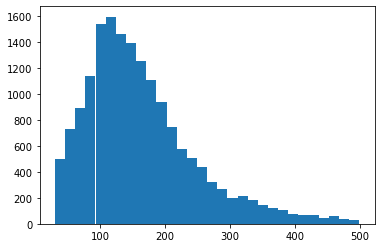

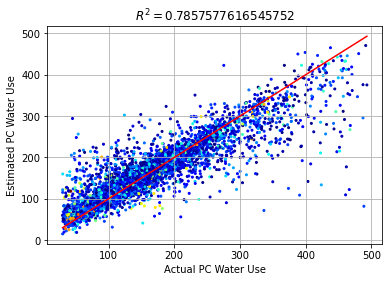

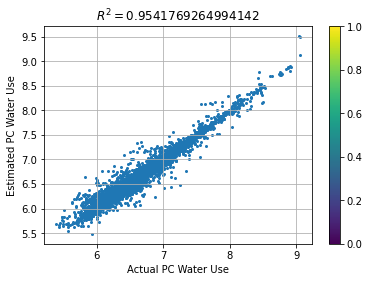

In [53]:

columns_to_drop = [ 'sys_id', 'wu_rate',  'sample_id'] + extra_drop#'population',
df = dataset.copy()
#df['pc_median']
df['pc'] = df['wu_rate']/df['pop']
if 1:
    df = df[df['pop']>8000]
    mask = (df['pc']>30) & (df['pc']<500)
    df = df[mask]
    #df = df[df['pc']<df['p95']]
    #df = df[df['pc']>df['p5']]

#mask = ((df['pc_median']-df['pc'])/df['pc_median']) <0.5
#df = df[mask]

df = df.drop(columns_to_drop, axis=1)
features = list(df.columns)
features.remove('pc')
X =df[features]
from statsmodels.distributions.empirical_distribution import ECDF
# y = df['pc'].values
# ec = ECDF(y)
# y = ec(y)
y =df['pc']

# 
plt.figure()
v_freq = plt.hist(df['pc'].values, bins = 30)
freq = np.interp(df['pc'].values, v_freq[1][1:], v_freq[0], left=None, right=None, period=None)
X['freq'] = freq

tar_ec = ce.TargetEncoder(return_df=True, cols = ['county_id'] )
#X = tar_ec.fit_transform(X, y)

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 123)
Train_freq = X_train['freq']
Test_freq = X_test['freq']
del(X_test['freq'])
del(X_train['freq'])

lgb_params = {
    'n_jobs': 1,
    'max_depth': 8,
    'min_data_in_leaf': 20,
    'subsample': 0.5,
    'n_estimators': 500,
    'learning_rate': 0.2,
    'colsample_bytree': 0.5,
    'boosting_type': 'gbdt',
   
}

# Estimator  -- reg:squaredlogerror, "reg:squarederror"
if 1:
    gb = xgb.XGBRegressor(objective="reg:squarederror", tree_method = 'hist', colsample_bytree=0.8, learning_rate=0.20,
                                  max_depth=7, alpha=100,  n_estimators=500, rate_drop=0.9, skip_drop=0.5, subsample=0.8,
                                  seed = 123, reg_lambda=10, min_child_weight = 1, gamma = 10, max_delta_step = 0, 
                               )
else:
    gb = LGBMRegressor(objective='regression', alpha=quantile_alpha, **lgb_params)


main_pipeline = []

# (A.2) transformation of categorical features

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# (A.3)do all preprocessing
if 1: # r2 = 0.785
    preprocessor = ColumnTransformer(remainder = 'passthrough',
        transformers=[       
            ("cat", categorical_transformer, categorical_features),
            ('Target encoding', ce.OneHotEncoder( cols = ['county_id',
                                                          'KG_climate_zone']), ['county_id','KG_climate_zone' ])
        ]
    )
    main_pipeline.append(('preprocess', preprocessor))

# drop r2 to 0.774
if 0:
    from feature_engine.encoding import CountFrequencyEncoder
    encoder = CountFrequencyEncoder(encoding_method='frequency',
                             variables=categorical_features)
    main_pipeline.append(('enc', encoder))

# drop r2 to 0.663 for ordered and 0.78 for arbitrary
if 0:    
    from feature_engine.encoding import OrdinalEncoder
    encoder = OrdinalEncoder(encoding_method='ordered',
                             variables=categorical_features)
    main_pipeline.append(('enc', encoder))

#***************************




main_pipeline.append(('model', gb))

model = Pipeline(main_pipeline)



w = 1.0/Train_freq
w = w/np.max(w)

kwargs = {model.steps[-1][0] + '__sample_weight': w/w}
model.fit(X_train, y_train, **kwargs)

plt.figure()
ypredict = model.predict(X_test)

w2 = 1.0/Test_freq
w2 = w2/np.max(w2)

accuracy = r2_score(y_test, ypredict, sample_weight=w2/w2)
accuracy

plt.scatter(y_test, ypredict, s = 4, c = np.log10(X_test['pop']), cmap = 'jet')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()

plt.figure()
plt.scatter(np.log10(y_test*X_test['pop']), np.log10(ypredict*X_test['pop']), s = 4)
accuracy =  r2_score(np.log10(y_test*X_test['pop']),  np.log10(ypredict*X_test['pop']))
#plt.plot([min(y_test*X_test['pop']), max(ypredict*X_test['pop'])], [min(y_test*X_test['pop']), max(y_test)*X_test['pop']], 'r')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()

plt.colorbar()
plt.show()

In [ ]:
e = np.abs(y_test- ypredict)
mask = e>150

In [ ]:
plt.figure()
plt.scatter(X_test[mask]['LONG'], X_test[mask]['LAT'], c =  X_test[mask]['pop'], cmap = 'jet', s = 4)
plt.colorbar()

In [ ]:
X_test.LONG

In [ ]:
features = X_test.columns
imp = []
for feature in features:
    X_test_permutated = X_test.copy()
    val = X_test_permutated[feature].sample(frac = 1)
    val = val.values
    X_test_permutated[feature] = val
    y_predicted_per = model.predict(X_test_permutated)
    accuracy = r2_score(y_test, y_predicted_per)
    print(accuracy)
    imp.append(accuracy - 0.7714)

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF

In [ ]:
x = df['pc'].values
ec = ECDF(x)

In [ ]:
ec(x)

In [ ]:
ytrain_predicted = model.predict(X_train)
plt.figure()




accuracy = r2_score(y_train, ytrain_predicted)
accuracy

plt.scatter(y_train, ytrain_predicted, s = 4)
plt.plot([min(y_train), max(y_train)], [min(ytrain_predicted), max(ytrain_predicted)], 'r')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()

plt.colorbar()
plt.show()

## Meaure Importance 

In [ ]:
features = X_test.columns
imp = []
for feature in features:
    X_test_permutated = X_test.copy()
    val = X_test_permutated[feature].sample(frac = 1)
    val = val.values
    X_test_permutated[feature] = val
    y_predicted_per = model.predict(X_test_permutated)
    accuracy = r2_score(y_test, y_predicted_per)
    print(accuracy)
    imp.append(accuracy - 0.7714)
    
imp = np.array(imp)   
plt.figure()
plt.bar(features[np.argsort(imp)][0:50], imp[np.argsort(imp)[0:50]]) 

In [ ]:
ordered_features = features[np.argsort(imp)]

In [ ]:
features = np.array(features)
feat_to_drop = features[np.argsort(imp)][70:]
feat_to_drop = feat_to_drop.tolist()

In [ ]:
feat_to_drop = feat_to_drop.tolist()

In [ ]:
feat_to_drop

In [ ]:
feat_to_drop.remove('KG_climate_zone')

In [ ]:
plt.figure()
plt.bar(features[np.argsort(imp)][0:50], imp[np.argsort(imp)[0:50]])

In [ ]:
imp[np.argsort(imp)[0:50]]

In [ ]:
len(features)-60

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.decomposition import PCA

pipeline = Pipeline([ ('disc', KBinsDiscretizer(n_bins=1000, encode='ordinal', strategy='uniform')),                     
                    ('model', gb)])
kwargs = {pipeline.steps[-1][0] + '__sample_weight': w/w}
pipeline.fit(X_train, y_train, **kwargs)

plt.figure()
ypredict = pipeline.predict(X_test)

w2 = 1.0/Test_freq
#w2 = w2/np.sum(w)
w2 = w2/np.max(w2)

accuracy = r2_score(y_test, ypredict, sample_weight=w2/w2)
accuracy

plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()

## Pipeline
### Categorical encoding

In [ ]:
# (A.2) transformation of categorical features
categorical_features = ['HUC2', 'state_id',  'KG_climate_zone', 'county_id' ]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")



In [ ]:
# drop_before_preprocess = ['sys_id']
# categorical_features = ['HUC2', 'state_id',  'KG_climate_zone', 'county_id' ]
# ohc1 = MultiOneHotEncoder(catfeatures = categorical_features )
# dataset = ohc1.transform(dataset)

In [ ]:
# for i in dataset.columns:
#     print(i)

# Estimating Water Use without Log transformation

In [ ]:
# columns to drop
columns_to_drop = ['population', 'sys_id', 'pc']
df = dataset.copy()
df['pc'] = df['wu_rate']/df['pop']
df = df[df['pop']>100]
mask = (df['pc']>20) & (df['pc']<500)
df = df[mask]

df = df.drop(columns_to_drop, axis=1)
features = list(df.columns)
features.remove('wu_rate')
X =df[features]
y = df['wu_rate']

In [ ]:
df.columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

In [ ]:
#squaredlogerror
#squarederror
gb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.8, learning_rate=0.1,
                              max_depth=7, alpha=0.01, n_estimators=500, rate_drop=0.9, skip_drop=0.5, subsample=0.8,
                              seed = 123, reg_lambda=0.0)

In [ ]:
gb.fit(X_train, y_train)

In [ ]:
ypredict = gb.predict(X_test)
accuracy = r2_score(y_test, ypredict)

In [ ]:
plt.figure()
accuracy = int(accuracy*100)/100.0
plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual Water Use")
plt.ylabel("Estimated Water Use")
plt.grid()
plt.show()

## Log water use & population 

In [ ]:
# columns to drop
columns_to_drop = ['population', 'sys_id', 'pc']
df = dataset.copy()
df = df[df['wu_rate']>100]
df['pc'] = df['wu_rate']/df['pop']
df = df[df['pop']>100]
mask = (df['pc']>20) & (df['pc']<500)
df = df[mask]

df = df.drop(columns_to_drop, axis=1)
df['pop'] = np.log10(df['pop'])
df['wu_rate'] = np.log10(df['wu_rate'])
features = list(df.columns)
features.remove('wu_rate')


X =df[features]
y = df['wu_rate']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

In [ ]:
gb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.8, learning_rate=0.01,
                              max_depth=7, alpha=0.01, n_estimators=500, rate_drop=0.9, skip_drop=0.5, subsample=0.8,
                              seed = 123, reg_lambda=0.0)

In [ ]:
gb.fit(X_train, y_train)

In [ ]:
ypredict = gb.predict(X_test)
accuracy = r2_score(y_test, ypredict)
accuracy

In [ ]:
plt.figure()
accuracy = int(accuracy*100)/100.0
plt.scatter(10**y_test, 10**ypredict, s = 4)
plt.plot([min(10**y_test), max(10**y_test)], [min(10**y_test), max(10**y_test)], 'r')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual Water Use")
plt.ylabel("Estimated Water Use")
plt.grid()
plt.show()

In [ ]:
plt.figure()
pc_test = (10**y_test)/(10**X_test['pop'])
pc_predict =  (10**ypredict)/(10**X_test['pop'])
accuracy = r2_score(pc_test, pc_predict )
plt.scatter(pc_test, pc_predict, s = 4)

plt.plot([min(pc_test), max(pc_test)], [min(pc_test), max(pc_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual Water Use")
plt.ylabel("Estimated Water Use")
plt.grid()
plt.show()

## Quantile Regression

## Use Xgboost

In [ ]:
# # columns to drop
# columns_to_drop = ['population', 'sys_id', 'pc']
# df = dataset.copy()
# df = df[df['wu_rate']>0]
# df['pc'] = df['wu_rate']/df['pop']
# df = df[df['pop']>1000]
# mask = (df['pc']>20) & (df['pc']<400)
# df = df[mask]

# df = df.drop(columns_to_drop, axis=1)
# df['pop'] = np.log10(df['pop'])
# df['wu_rate'] = np.log10(df['wu_rate'])
# features = list(df.columns)
# features.remove('wu_rate')


# X =df[features]
# y = df['wu_rate']

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

In [ ]:
def myfunc(quantile):
    def _myfunc(y_true, y_pred):
        errors = y_pred - y_true
        left_mask = errors < 0
        right_mask = errors > 0

        grad = -quantile * left_mask + (1 - quantile) * right_mask
        hess =  np.ones_like(y_pred)

        return grad, hess
    return _myfunc

In [ ]:
# log cosh quantile is a regularized quantile loss function
def log_cosh_quantile(alpha):
    def _log_cosh_quantile(y_true, y_pred):
        err = y_pred - y_true
        err = np.where(err < 0, alpha * err, (1 - alpha) * err)
        grad = np.tanh(err)
        hess = 1 / np.cosh(err)**2
        hess[hess<0.01] =0.01 
        #hess = np.ones_like(hess)
        
        return grad, hess
    return _log_cosh_quantile

In [ ]:
1 / np.cosh(-1000)**2

In [ ]:
def original_quantile_loss(alpha,delta):
    def _original_quantile_loss(y_true,y_pred):
        x = y_true - y_pred
        grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
        hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
        return grad,hess
    return _original_quantile_loss

In [ ]:
quantile_alphas = [0.1, 0.5, 0.90]

xgb_quantile_alphas = {}
for quantile_alpha in quantile_alphas:
    # to train a quantile regression, we change the objective parameter and
    # specify the quantile value we're interested in
    gb = xgb.XGBRegressor(objective=log_cosh_quantile(quantile_alpha), colsample_bytree=0.8, learning_rate=0.05,
                              max_depth=5, alpha=0.01, n_estimators=500, rate_drop=0.9, skip_drop=0.5, subsample=0.8,
                              seed = 323, reg_lambda=0.01)
    gb.fit(X_train, y_train)
    xgb_quantile_alphas[quantile_alpha] = gb

In [ ]:
plt.figure()
for quantile_alpha, lgb in xgb_quantile_alphas.items():
    ypredict = lgb.predict(X_test)
    plt.scatter(10**y_test, 10**ypredict, s = 4, label = "{}".format
                (quantile_alpha))
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.legend()
lim = [min(10**y_test), max(10**y_test)]
plt.plot(lim, lim, 'k')
plt.xlabel("Actual Water Use")
plt.ylabel("Estimated Water Use")

## Use Ligh GBM

In [ ]:
lgb_params = {
    'n_jobs': 1,
    'max_depth': 8,
    'min_data_in_leaf': 10,
    'subsample': 0.8,
    'n_estimators': 500,
    'learning_rate': 0.1,
    'colsample_bytree': 0.8,
    'boosting_type': 'gbdt'
}

In [ ]:
quantile_alphas = [0.1, 0.5, 0.90]

lgb_quantile_alphas = {}
for quantile_alpha in quantile_alphas:
    # to train a quantile regression, we change the objective parameter and
    # specify the quantile value we're interested in
    lgb = LGBMRegressor(objective='quantile', alpha=quantile_alpha, **lgb_params)
    lgb.fit(X_train, y_train)
    lgb_quantile_alphas[quantile_alpha] = lgb

In [ ]:
plt.figure()
for quantile_alpha, lgb in lgb_quantile_alphas.items():
    ypredict = lgb.predict(X_test)
    plt.scatter(y_test, ypredict, s = 4, label = "{}".format
                (quantile_alpha))
# plt.gca().set_yscale('log')
# plt.gca().set_xscale('log')
plt.legend()
lim = [min(y_test), max(y_test)]
plt.plot(lim, lim, 'k')
plt.xlabel("Actual Water Use")
plt.ylabel("Estimated Water Use")

# Dimension-reduction

In [ ]:
columns_to_drop = ['population', 'sys_id', 'wu_rate', 'pop', 'households2', 'n_employed', 'n_houses']
df = dataset.copy()

df['pc'] = df['wu_rate']/df['pop']
df = df[df['pop']>100]
mask = (df['pc']>20) & (df['pc']<500)
df = df[mask]


df = df.drop(columns_to_drop, axis=1)
features = list(df.columns)
features.remove('pc')
X =df[features]
y = df['pc']

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10, whiten = True)
pca.fit(X)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

In [ ]:
pca.transform(X)

# Testing more ideas for estimating Per Capita 

In [ ]:
def make_dataset(dataset = dataset, filters = [], drop_cols = [] ):
    pass
    


## No action

In [ ]:
 
columns_to_drop = ['population', 'sys_id', 'wu_rate']
df = dataset.copy()

df['pc'] = df['wu_rate']/df['pop']
df = df[df['pop']>100]
mask = (df['pc']>20) & (df['pc']<500)
df = df[mask]


df = df.drop(columns_to_drop, axis=1)
features = list(df.columns)
features.remove('pc')
X =df[features]
y = df['pc']

#squarederror
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)
gb = xgb.XGBRegressor(objective="reg:squarederror", colsample_bytree=0.8, learning_rate=0.1,
                              max_depth=7, alpha=0.01, n_estimators=500, rate_drop=0.9, skip_drop=0.5, subsample=0.8,
                              seed = 123, reg_lambda=0.0)

w = np.exp(1e-2*np.power((y_train-200)/10, 2.0))
w = w/np.sum(w)
w = w.values
w = w/np.max(w)
gb.fit(X_train, y_train, sample_weight=w/w)
plt.figure()
ypredict = gb.predict(X_test)

w2 = np.exp(1e-3*np.power((y_test-200)/10, 2.0))
w2 = w2/np.sum(w)
w2 = w2.values
w2 = w2/np.max(w2)

accuracy = r2_score(y_test, ypredict, sample_weight=w2/w2)
accuracy

plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()

In [ ]:

columns_to_drop = ['population', 'sys_id', 'wu_rate']
df = dataset.copy()
del(df['pc_median'])
df['pc'] = df['wu_rate']/df['pop']
df = df[df['pop']>1000]
mask = (df['pc']>20) & (df['pc']<500)
df = df[mask]


df = df.drop(columns_to_drop, axis=1)
features = list(df.columns)
features.remove('pc')
X =df[features]
y = df['pc']

# 
plt.figure()
v_freq = plt.hist(df['pc'].values, bins = 30)
freq = np.interp(df['pc'].values, v_freq[1][1:], v_freq[0], left=None, right=None, period=None)
X['freq'] = freq
#squarederror
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 123)
Train_freq = X_train['freq']
Test_freq = X_test['freq']
del(X_test['freq'])
del(X_train['freq'])

#squarederror
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)
gb = xgb.XGBRegressor(objective="reg:squarederror", tree_method = 'hist', colsample_bytree=0.8, learning_rate=0.20,
                              max_depth=7, alpha=100,  n_estimators=500, rate_drop=0.9, skip_drop=0.5, subsample=0.8,
                              seed = 123, reg_lambda=10, min_child_weight = 1, gamma = 10, max_delta_step = 0, 
                           )
#gb = xgb.XGBRegressor(objective="reg:squarederror" )


w = 1.0/Train_freq
#w = w/np.sum(w)
w = w/np.max(w)
gb.fit(X_train, y_train, sample_weight=w/w)
plt.figure()
ypredict = gb.predict(X_test)

w2 = 1.0/Test_freq
#w2 = w2/np.sum(w)
w2 = w2/np.max(w2)

accuracy = r2_score(y_test, ypredict, sample_weight=w2/w2)
accuracy

plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()

# Use Pipeline 


In [ ]:


# (A.1) transformation of numeric features
numeric_features = ["age", "fare"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# (A.2) transformation of categorical features
categorical_features = ["embarked", "sex", "pclass"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")


# (A.3)do all preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

#  (B.1) complete pipeline
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

In [ ]:
from sklearn import set_config

set_config(display="diagram")
clf

In [ ]:
## Scaling

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pipeline = Pipeline([ ('robost_scaler', RobustScaler()),                     
                    ('model', gb)])
kwargs = {pipeline.steps[-1][0] + '__sample_weight': w/w}
pipeline.fit(X_train, y_train, **kwargs)

plt.figure()
ypredict = pipeline.predict(X_test)

w2 = 1.0/Test_freq
#w2 = w2/np.sum(w)
w2 = w2/np.max(w2)

accuracy = r2_score(y_test, ypredict, sample_weight=w2/w2)
accuracy

plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

from sklearn.decomposition import PCA

pipeline = Pipeline([ ('uniform_dist', PowerTransformer()),                     
                    ('model', gb)])
kwargs = {pipeline.steps[-1][0] + '__sample_weight': w/w}
pipeline.fit(X_train, y_train, **kwargs)

plt.figure()
ypredict = pipeline.predict(X_test)

w2 = 1.0/Test_freq
#w2 = w2/np.sum(w)
w2 = w2/np.max(w2)

accuracy = r2_score(y_test, ypredict, sample_weight=w2/w2)
accuracy

plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.decomposition import PCA

pipeline = Pipeline([ ('disc', KBinsDiscretizer(n_bins=1000, encode='ordinal', strategy='uniform')),                     
                    ('model', gb)])
kwargs = {pipeline.steps[-1][0] + '__sample_weight': w/w}
pipeline.fit(X_train, y_train, **kwargs)

plt.figure()
ypredict = pipeline.predict(X_test)

w2 = 1.0/Test_freq
#w2 = w2/np.sum(w)
w2 = w2/np.max(w2)

accuracy = r2_score(y_test, ypredict, sample_weight=w2/w2)
accuracy

plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()

In [ ]:
# plot feature importance
# ‘weight’: the number of times a feature is used to split the data across all trees.

# ‘gain’: the average gain across all splits the feature is used in.

# ‘cover’: the average coverage across all splits the feature is used in.

# ‘total_gain’: the total gain across all splits the feature is used in.

# ‘total_cover’: the total coverage across all splits the feature is used in.
plot_importance(gb,   xlabel='total_gain', importance_type='total_gain', max_num_features = 10)
from sklearn.feature_selection import SelectFromModel
plt.tight_layout()

In [ ]:
# Another look at importance

In [ ]:
plt.figure()
ypredict = gb.predict(X_test)

w2 = 1.0/Test_freq
#w2 = w2/np.sum(w)
w2 = w2/np.max(w2)

accuracy = r2_score(y_test, ypredict, sample_weight=w2/w2)
accuracy

plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()

In [ ]:
# Tuning
gb.get_params()
# params = {'colsample_bylevel': scipy.stats.uniform (loc = 0.1, scale=0.9),
#     'colsample_bynode': scipy.stats.uniform (loc = 0.1, scale=0.9),
#     'colsample_bytree': scipy.stats.uniform (loc = 0.1, scale=0.9),
#     'gamma': scipy.stats.uniform (loc = 0, scale=100),
#     'learning_rate': scipy.stats.uniform (loc = 0.001, scale=0.4),
#     'max_depth': [3,4,5,6,7,8,9, 10],
#     'min_child_weight' : scipy.stats.uniform (loc = 0 scale=1000),
#     'reg_alpha': 100,
#      'reg_lambda': 10,
#      'subsample': 0.8
#     }

In [ ]:
from pycaret.regression import *

columns_to_drop = ['population', 'sys_id', 'wu_rate']
df = dataset.copy()
del(df['pc_median'])
df['pc'] = df['wu_rate']/df['pop']
df = df[df['pop']>1000]
mask = (df['pc']>20) & (df['pc']<500)
df = df[mask]


df = df.drop(columns_to_drop, axis=1)
data = df.sample(frac=0.9, random_state=786)
data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

exp0 = setup(data = data2, target = 'pc', train_size = 0.8,                   
                   fold_shuffle= True, data_split_shuffle=True, session_id=123)
xgb = create_model('xgboost', fold = 3)
tuned_ada = tune_model(xgb)

In [ ]:
tuned_ada = tune_model(xgb)

In [ ]:
columns_to_drop = ['population', 'sys_id', 'wu_rate']
df = dataset.copy()

df['pc'] = df['wu_rate']/df['pop']
df = df[df['pop']>100]
mask = (df['pc']>20) & (df['pc']<500)
df = df[mask]


df = df.drop(columns_to_drop, axis=1)
features = list(df.columns)
features.remove('pc')
X =df[features]
y = df['pc']

In [ ]:
columns_to_drop = ['population', 'sys_id', 'wu_rate']
df = dataset.copy()

df['pc'] = df['wu_rate']/df['pop']
df = df[df['pop']>100]
mask = (df['pc']>20) & (df['pc']<500)
df = df[mask]


df = df.drop(columns_to_drop, axis=1)
features = list(df.columns)
features.remove('pc')
X =df[features]
y = df['pc']

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20, whiten = True)
pca.fit(X)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)
X = pca.transform(X)

In [ ]:
#squarederror
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)
gb = xgb.XGBRegressor(objective='reg:"squarederror"', colsample_bytree=0.8, learning_rate=0.1,
                              max_depth=7, alpha=0.01, n_estimators=500, rate_drop=0.9, skip_drop=0.5, subsample=0.8,
                              seed = 123, reg_lambda=0.0)
gb.fit(X_train, y_train)

In [ ]:
plt.figure()
ypredict = gb.predict(X_test)
accuracy = r2_score(y_test, ypredict)
accuracy
accuracy = int(accuracy*100)/100.0
plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()

## Quantile transformation of the target PC
### Uniform Distribution

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import quantile_transform
from scipy import stats
x = pd.DataFrame(np.random.rand(100), columns = ['x'])
stats.percentileofscore(x['x'], 0.47219 )

In [ ]:
from scipy import stats

In [ ]:
# quantile transform
# columns to drop
columns_to_drop = ['population', 'sys_id', 'wu_rate']
df = dataset.copy()

df['pc'] = df['wu_rate']/df['pop']
df = df[df['pop']>100]
mask = (df['pc']>20) & (df['pc']<500)
df = df[mask]
pc_max = df['pc'].max()
pc_min = df['pc'].min()

df = df.drop(columns_to_drop, axis=1)
wu = quantile_transform(df['pc'].values.reshape(len(df),1), n_quantiles=5000, 
                        random_state=0) #, output_distribution = 'normal'
df['pc'] = wu.flatten()
features = list(df.columns)
features.remove('pc')
X =df[features]
y = df['pc']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

In [ ]:
#squarederror
gb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.8, learning_rate=0.1,
                              max_depth=7, alpha=0.01, n_estimators=500, rate_drop=0.9, skip_drop=0.5, subsample=0.8,
                              seed = 123, reg_lambda=0.0)

In [ ]:
gb.fit(X_train, y_train)

In [ ]:
plt.figure()
ypredict = gb.predict(X_test)
accuracy = r2_score(y_test, ypredict)
accuracy
accuracy = int(accuracy*100)/100.0
plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual Water Use")
plt.ylabel("Estimated Water Use")
plt.grid()
plt.show()

In [ ]:
plt.figure()
ypredict = gb.predict(X_test)
ypredict = pc_min + ypredict*(pc_max-pc_min)
y_test = pc_min + y_test*(pc_max-pc_min)
accuracy = r2_score(y_test, ypredict)
accuracy
accuracy = int(accuracy*100)/100.0
plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()

## Normal Distribution

In [ ]:
# quantile transform
# columns to drop
columns_to_drop = ['population', 'sys_id', 'wu_rate']
df = dataset.copy()

df['pc'] = df['wu_rate']/df['pop']
df = df[df['pop']>100]
mask = (df['pc']>20) & (df['pc']<500)
df = df[mask]
pc_mean = df['pc'].mean()
pc_std= df['pc'].std()

df = df.drop(columns_to_drop, axis=1)
wu = quantile_transform(df['pc'].values.reshape(len(df),1), n_quantiles=5000, 
                        random_state=0, output_distribution = 'normal') #, output_distribution = 'normal'
df['pc'] = wu.flatten()
features = list(df.columns)
features.remove('pc')
X =df[features]
y = df['pc']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

In [ ]:
gb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.8, learning_rate=0.1,
                              max_depth=7, alpha=0.01, n_estimators=500, rate_drop=0.9, skip_drop=0.5, subsample=0.8,
                              seed = 123, reg_lambda=0.0)

In [ ]:
gb.fit(X_train, y_train)

In [ ]:
plt.figure()
ypredict = gb.predict(X_test)
accuracy = r2_score(y_test, ypredict)
accuracy
accuracy = int(accuracy*100)/100.0
plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()

In [ ]:
pc_std

In [ ]:
plt.figure()
ypredict = gb.predict(X_test)

ypredict= 180+pc_mean + pc_std * ypredict
y_test = 180+pc_mean + pc_std * y_test
accuracy = r2_score(y_test, ypredict)

accuracy = int(accuracy*100)/100.0
plt.scatter(y_test, ypredict, s = 4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')

plt.title("$R^2 = ${}".format(accuracy))
plt.xlabel("Actual PC Water Use")
plt.ylabel("Estimated PC Water Use")
plt.grid()
plt.show()